## Import libraries

In [73]:
# Set the seed for reproducibility
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, SelectFromModel
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
import pickle
import h5py
import cv2
import statistics
import functools
from collections import Counter
import zipfile
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from scipy.stats import ttest_ind




## Data Load

### patients labels load

In [150]:
file_path = "../data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Extraction of numbers from patients names
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


### Encoders features load

In [223]:
### choose the network between ["VGG", "ResNet", "IncRes", "Inception"]
network_name='ResNet'

### choose the image type between ["Full", "Cut"]
type_image='Cut'

In [224]:
## csv file for features extracted by the network
file_path = f"../CSVFeatures/2D/{type_image}/{network_name}_SliceMaggiore_{type_image}.csv" 
df = pd.read_csv(file_path, sep=',')

df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print("Number of features: ", features.shape[1])  



[[0.         0.         0.5969644  ... 0.5752966  0.07278237 0.06921518]
 [2.9802222  0.         0.         ... 0.         0.         0.        ]
 [2.4853635  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.06428157 0.         0.34221166 ... 0.73955196 0.         0.        ]
 [1.4031482  0.         0.         ... 0.         0.         0.        ]
 [0.44237566 0.         0.5097674  ... 0.634623   0.766255   0.        ]]
Number of features:  2048


### Radiomics features load

In [323]:
## csv file for radiomic features
file_path = "../CSVFeatures/2D/Radiomica_Wavelet_2D.csv"

df = pd.read_csv(file_path, sep=',')

# Remove unnecessary columns
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print("Number of features: ", features.shape[1])  
network_name='Rad'

[[5.83888273e-01 2.49810487e+01 2.57099203e+01 ... 5.69700030e+03
  5.01293376e-01 1.88681815e+02]
 [8.68120272e-01 2.78353641e+01 2.75136330e+01 ... 1.17856494e+04
  4.99502216e-01 2.32884640e+02]
 [6.68428011e-01 3.34967625e+01 3.44818793e+01 ... 1.10016612e+03
  1.37685835e-01 1.17271924e+02]
 ...
 [8.95387032e-01 3.24479655e+01 2.80178515e+01 ... 3.74357530e+02
  3.76839859e-01 4.56595117e+01]
 [7.82116308e-01 2.65896102e+01 2.56320112e+01 ... 1.71247332e+04
  8.63664634e-01 1.86559244e+02]
 [5.58702485e-01 3.61138047e+01 3.58468967e+01 ... 1.35620356e+04
  4.73861210e-01 2.66695842e+02]]
Number of features:  474


## Functions

In [6]:

## Removal features by Pearson Correlation 
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Removal features by p_value using ANOVA F-test
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## Function to remove selected features
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


# Sorting personalized 
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # If the difference between the balanced accuracies is less than 0.001, compare the ROC AUC
    if abs(balacc1 - balacc2) < 0.003:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Compare the ROC AUC and return -1, 0, or 1 for sorting
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Otherwise orders for balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0


In [207]:
## classifier initialization function
def classifierinitialization(classifier):
    if classifier == 'RF':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'LR':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XGBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi


## CLASSIFICATION FUNCTION with 
# 'selector' mode that is the one used by the validation folds and 
# 'features' mode that is used by the test set which takes as input directly the selected_features array
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="selector", selected_features=[0], filename=None):

    if mode == "selector":
            selected_features = None 
            
            if selector == "LASSO":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "LR":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mRMR":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "RF":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
                return

            x_test = x_test[:, selected_features]  # same feature selection on test set
            number_features = len(selected_features)

        # Classifier Training
            classifier.fit(X_selected, y_train_expanded)

    ### used for the test set, no feature selection through selector but used selected_features
    elif mode == "features": 
        if selected_features is None or len(selected_features) == 0:
            print("Error: selected_features must be provided in 'features' mode.")
            return
        
        # Usa solo le selected features su train e test
        X_selected = x_train_expanded[:, selected_features]
        x_test = x_test[:, selected_features]

        number_features = len(selected_features)

        # Classifier Training on train + validation
        classifier.fit(X_selected, y_train_expanded)
        ## save in a file the trained classifier to then use it for 2.5D
        if(filename != None):
            with open(filename, "wb") as file:
                pickle.dump(classifier, file)
    
    else:
           print("Error, choose between: selector / features")

    # Predict probabilities
    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    # Fixed threshold to 0.5
    threshold = 0.5

    # Predict using the fixed threshold
    y_pred_custom_test = (y_proba_test >= threshold).astype(int)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)

    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)

    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    best_case = {
            'alpha': alpha,
            'num_features': number_features,
            'selected_features': selected_features,
            'pr_auc': pr_auc,
            'roc_auc': roc_auc,
            'f1': f1,
            'accuracy': accuracy,
            'confusion_matrix': conf,
            'balanced accuracy': bal_acc,
            'y_pred': y_pred_custom_test,
            'y_proba': y_proba_test
    }

    return best_case


### train function for ensemble method
def train_classifier_ensemble(classifier_type,  selector, x_train_expanded, y_train_expanded, num_features, X_test, selected_features = None):
    
    classifier = classifierinitialization(classifier_type)
    if(selected_features is None):
        if selector == "LASSO":
            X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, num_features)
        elif selector == "LR":
            X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "mRMR":
            X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
        elif selector == "RF":
            X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
        else:
            print("Wrong selector. Choose between: mRMR, RF, LR, LASSO")
            return
        
        X_test_selected = X_test[:, selected_features]
        classifier.fit(X_selected, y_train_expanded)
    else:
        X_selected = x_train_expanded[:, selected_features]
        X_test_selected = X_test[:, selected_features]
        classifier.fit(X_selected, y_train_expanded)
    
    return classifier, X_test_selected



def classification_with_trained_classifier(classifier, x_test, y_test, selected_features):

    x_test = x_test[:, selected_features]

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    y_pred_custom_test = (y_proba_test >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)

    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    best_case = {
        'num_features': len(selected_features),
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'balanced accuracy': bal_acc
    }

    return best_case

## split + feature correlation and p_value

In [225]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False)


print("Number of train patients: ", len(X_train))
print("Number of test patients: ", len(y_test))
print("Number of features for every image: ", X_train[0].shape[0] )

original_features=np.arange(X_train.shape[1])


## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.9)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)
original_features=np.delete(original_features,dropped_features)

print("Features kept after correlation: ", X_train_reduced.shape[1])


# Removal of features with high ANOVA F-test p_value
X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
X_test_reduced = X_test_reduced[:, features_to_keep]
original_features=original_features[features_to_keep]
print("Features kept after p_value: ", X_train_reduced.shape[1])


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  2048
Features kept after correlation:  915
Features kept after p_value:  142


## Cross Validation

In [154]:
####### alpha parameters
alpha_rad= np.linspace(0.0008, 0.1, 50).tolist()

alpha_VGG_Cut = np.linspace(0, 0.005, 10)
alpha_Inception_Cut = np.linspace(0.0005, 0.01, 30)
alpha_ResNet_Cut= np.linspace(0.0002, 0.02, 30)
alpha_IncRes_Cut = np.linspace(0.0005, 0.01, 30)
alpha_VGG_Full = np.linspace(2.8, 50, 50).tolist()
alpha_ResNet_Full= np.linspace(0.006, 0.05, 30).tolist()
alpha_Inception_Full= np.linspace(0.001, 0.05, 20).tolist()
alpha_IncRes_Full= np.linspace(0.007, 0.02, 30).tolist()

if(network_name=='Rad'):
    alpha_values=alpha_rad
else:
    alpha_values=globals()[f"alpha_{network_name}_{type_image}"]


classifiers=['XGBoost',  'SVM', 'ensemble','RF', 'LR', 'MLP']
selectors=['mRMR','RF', 'LR', 'LASSO']

In [155]:
classifiers=['LR']
selectors = ['mRMR']

In [156]:

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None,
                'predizioni':[]
            }


results_val_others = [template_dict.copy() for _ in range(5000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(5000)]
results_val_lasso.append(template_dict.copy())

results_test_others = [template_dict.copy() for _ in range(5000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(5000)]
results_test_lasso.append(template_dict.copy())

## setting the max number of features to be tested to 30
if(len(X_train_reduced[0])+1 < 30):
    limit=len(X_train_reduced[0])
else:
    limit=30

## SMOTE
smote = SMOTE(random_state=10)

k=0
u=0

## Stratified Cross validation 5 folds
n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)




In [157]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    

    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)
                if(selector=='LASSO'):

                    for alpha in alpha_values:
                        #print("Doing alpha ", alpha )
                        classi= classifierinitialization(classifier)
                        best_case_val= classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, mode="selector", selected_features=[0])
                        
                        #print(f"for {alpha} found {best_case_val['num_features'] }")

                        if(best_case_val==0 or best_case_val['num_features']> limit):
                            best_case_val=template_dict
                            best_case_val['balanced accuracy'] = 0
                            best_case_val['accuracy'] = 0
                            best_case_val['f1'] = 0
                            best_case_val['roc_auc'] = 0
                            best_case_val['pr_auc'] = 0
                            best_case_val['selected_features'] = [0]
                            best_case_val['num_features'] = 0
                            best_case_val['confusion_matrix'] = 0
                            best_case_val['y_pred']=[0]
                            
                        #print(f"for {alpha} found {best_case_val['num_features'] }")
                        results_val_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy'],
                                            'predizioni':best_case_val['y_pred']
                                            }

                        #print(best_case_val['num_features'])
                        

                        if(fold_idx==0):
                            classi= classifierinitialization(classifier)
                            best_case_test= classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="selector", selected_features=[0])

                            if(best_case_test==0 or best_case_test['num_features']> limit):
                                best_case_test=template_dict
                                best_case_test['balanced accuracy'] = 0
                                best_case_test['accuracy'] = 0
                                best_case_test['f1'] = 0
                                best_case_test['roc_auc'] = 0
                                best_case_test['pr_auc'] = 0
                                best_case_test['selected_features'] = [0]
                                best_case_test['num_features'] = 0
                                best_case_test['confusion_matrix'] = 0
                                best_case_test['y_pred']=[0]
                            
                            results_test_lasso[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'pr_auc': best_case_test['pr_auc'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy'],
                                                'predizioni':best_case_test['y_pred']
                                                }
                            u=u+1
                        k = k + 1

                else:

                    for t in range(2, limit):
                            #print("doing features ", t)
                            classi= classifierinitialization(classifier)

                            best_case_val= classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, mode="selector", selected_features=[0])
                    
                                
                            results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                'predizioni':best_case_val['y_pred']
                                                }
                            #print(results_val_others[k]['f1'])

                            if(fold_idx==0):
                                classi= classifierinitialization(classifier)
                                best_case_test= classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, t, mode="selector", selected_features=[0])
                                
                                results_test_others[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'pr_auc': best_case_test['pr_auc'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy'],
                                                    'predizioni':best_case_test['y_pred']
                                                    }
                                u=u+1

                            k = k + 1

Starting with fold: 0
Starting with classifier: LR
Starting with selector: mRMR
Starting with fold: 1
Starting with classifier: LR
Starting with selector: mRMR
Starting with fold: 2
Starting with classifier: LR
Starting with selector: mRMR
Starting with fold: 3
Starting with classifier: LR
Starting with selector: mRMR
Starting with fold: 4
Starting with classifier: LR
Starting with selector: mRMR


### Find average metrics across folds

In [158]:
results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['classifier'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")


num_features_range = list(range(2, limit))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mRMR', 'RF', 'LR']

for classifier in classifiers:
    #print(f"Starting classifier {classifier}")
    for selector in selectors:
            #print(f"Starting selector {selector}")
            for num_features in num_features_range:
                    # fitler for num_features
                    filtered_results=[]
                    for res in results_val_others:
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calculate mean of the metrics
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        #  Calculate std of the metrics
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizes the results for the combination
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



selectors = ['LASSO']
for classifier in classifiers:
    #print(f"Starting classifier {classifier}")
    for selector in selectors:
        #print(f"Starting selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_lasso:
                    # fitler for alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calculate mean of the metrics
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        #  Calculate std of the metrics
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                         # Memorizes the results for the combination
                        grid_results_lasso[(classifier, selector, alpha)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }


sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)
sorted_results = sorted_results_others + sorted_results_lasso

# Combination ordering - first based on balanced accuracy, and if the difference is <0.003, it considers roc_auc
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)

Filtered results_test_lasso: 0 entries remaining
Filtered results_val_lasso: 0 entries remaining
Filtered results_test_others: 28 entries remaining
Filtered results_val_others: 140 entries remaining


### Best results on validation based on gridsearch

In [159]:
chosen_combination=1 ### which result to pass to the test set

n=4 # how many configurations to show
best_combinations = sorted_results[:n]


print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='LASSO'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")


    if(params[1]=='LASSO'):
        for p in range (0, len(results_test_lasso)):
                    if(results_test_lasso[p]['classifier']==params[0] and results_test_lasso[p]['alpha']==params[2]):
                            best_case=results_test_lasso[p]
                            break
    else:
        for p in range (0, len(results_test_others)): 
                    if(results_test_others[p]['classifier']==params[0] and results_test_others[p]['selector']==params[1] and results_test_others[p]['num_features']==params[2]):
                            best_case=results_test_others[p]
                            break

    
    if (i==chosen_combination):
           best_classifier=params[0]
           best_selector=params[1]
           best_param=params[2]



#### find the selected_features for best combination to pass to the test set 
selected_features_array=[]

if (best_selector == 'LASSO'):
    for res in results_val_lasso:
            if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_param):
                    selected_features_array.append(res['selected_features'])

else:
    for res in results_val_others:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_param):
            selected_features_array.append(res['selected_features'])


### Only keep the features selected by at least 3 out of the 5 folds
all_elements = np.concatenate(selected_features_array)
element_counts = Counter(all_elements)
selected_features = np.array([key for key, count in element_counts.items() if count >= 3])
original_2Dfeatures= original_features[selected_features]


# To save the originalfeaturesarray
#file_path_originalfeatures = f"../trainedmodels2D/{type_image}/original_2Dfeatures_{network_name}.csv"
#np.savetxt(file_path_originalfeatures, original_2Dfeatures, delimiter=",", fmt='%f')

Migliori 4 combinazioni di parametri:

#1:
Classifier: LR
Selector: mRMR
Num_features: 4
Performance medie sul val set: 
ROC AUC = 0.6247530864197531 (std = 0.03873127844967144), Balanced Accuracy = 0.6444444444444445 (std = 0.05168831684980108)

#2:
Classifier: LR
Selector: mRMR
Num_features: 5
Performance medie sul val set: 
ROC AUC = 0.6347530864197531 (std = 0.06595479338040684), Balanced Accuracy = 0.6319444444444444 (std = 0.0723356481111099)

#3:
Classifier: LR
Selector: mRMR
Num_features: 6
Performance medie sul val set: 
ROC AUC = 0.6422530864197531 (std = 0.06119876959124085), Balanced Accuracy = 0.6258333333333334 (std = 0.06376497645433754)

#4:
Classifier: LR
Selector: mRMR
Num_features: 3
Performance medie sul val set: 
ROC AUC = 0.5797530864197531 (std = 0.0731254685630677), Balanced Accuracy = 0.6269444444444445 (std = 0.06476304149134655)


## Test results on best model found

In [226]:
### here is to execute if you want to skip the validation, selected_features are saved as well as the trained classifier
selected_features=np.loadtxt(f"../trainedmodels2D/{type_image}/selected_features_{network_name}.csv", delimiter=",")
selected_features = selected_features.astype(int)
try:
    if len(selected_features) == 0:
                print()
except TypeError:
              selected_features = np.array([selected_features])
trained_classifier_filename=(f"../trainedmodels2D/{type_image}/{network_name}")
with open(trained_classifier_filename, 'rb') as file:
    trained_classifier = pickle.load(file)

best_case_test=classification_with_trained_classifier(trained_classifier, X_test_reduced, y_test, selected_features)
print("Results on test set:")
print(f" Selected: {selected_features} e are {len(selected_features)}")
print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
print(f" Accuracy: {best_case_test['accuracy']}")
print(f" F1: {best_case_test['f1']}")
print(f" roc_auc: {best_case_test['roc_auc']}")
print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

Results on test set:
 Selected: [139] e are 1
 Balanced Accuracy: 0.8194444444444444
 Accuracy: 0.8461538461538461
 F1: 0.75
 roc_auc: 0.8533950617283951
 confusion matrix: [[24  3]
 [ 3  9]]



In [161]:
### This version is to execute after the cross validation loop 
classi=classifierinitialization(best_classifier)
best_case_test= classification_method(best_selector, classi, None, X_train_reduced, Y_train, X_test_reduced, y_test, None, mode="features", selected_features=selected_features, filename=None)
print("Results on test set:")
print(f" Selected: {selected_features} e are {len(selected_features)}")
print(f"Classifier: {best_classifier}, selector: {best_selector}, num_features in selector: {best_param}")
print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
print(f" Accuracy: {best_case_test['accuracy']}")
print(f" F1: {best_case_test['f1']}")
print(f" roc_auc: {best_case_test['roc_auc']}")
print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

Results on test set:
 Selected: [139] e are 1
Classifier: LR, selector: mRMR, num_features in selector: 4
 Balanced Accuracy: 0.8194444444444444
 Accuracy: 0.8461538461538461
 F1: 0.75
 roc_auc: 0.8533950617283951
 confusion matrix: [[24  3]
 [ 3  9]]



### heatmap validation

finds best conf for each (classifier,selector)

In [1299]:
classifiers=['XGBoost',  'SVM', 'ensemble','RF', 'LR', 'MLP']
selectors=['mRMR','RF', 'LR', 'LASSO']

best_results_class_selector_template={
    'classifier': None,
    'selector': None,
    'num_features/alpha': None,
    'avg_balaccuracy': None,
    'std_balaccuracy': None,
    'avg_roc_auc':None,
    'std_roc_auc': None,
    'avg_f1': None,
    'std_f1': None,
}

best_results_class_selector = [best_results_class_selector_template.copy() for _ in range(23)]
best_results_class_selector.append(best_results_class_selector_template.copy())

i = 0
for classifier in classifiers:
    for selector in selectors:
        for params, metrics in sorted_results:
            if params[0] == classifier and params[1] == selector:
                best_results_class_selector[i]['classifier'] = params[0]
                best_results_class_selector[i]['selector'] = params[1]
                best_results_class_selector[i]['num_features/alpha'] = params[2]
                
                # Verifica se i valori sono tuple o scalari e assegna correttamente
                best_results_class_selector[i]['avg_balaccuracy'] = metrics['avg_balaccuracy'][0] if isinstance(metrics['avg_balaccuracy'], tuple) else metrics['avg_balaccuracy']
                best_results_class_selector[i]['std_balaccuracy'] = metrics['std_balaccuracy'][0] if isinstance(metrics['std_balaccuracy'], tuple) else metrics['std_balaccuracy']
                best_results_class_selector[i]['avg_roc_auc'] = metrics['avg_roc_auc'][0] if isinstance(metrics['avg_roc_auc'], tuple) else metrics['avg_roc_auc']
                best_results_class_selector[i]['std_roc_auc'] = metrics['std_roc_auc'][0] if isinstance(metrics['std_roc_auc'], tuple) else metrics['std_roc_auc']
                best_results_class_selector[i]['avg_f1'] = metrics['avg_f1'][0] if isinstance(metrics['avg_f1'], tuple) else metrics['avg_f1']
                best_results_class_selector[i]['std_f1'] = metrics['std_f1'][0] if isinstance(metrics['std_f1'], tuple) else metrics['std_f1']


                
                i += 1
                break


In [1197]:
metricaavg='avg_balaccuracy'
metricastd='std_balaccuracy'
metricanome= 'balanced accuracy'
labell='BA'

In [504]:
metricaavg='avg_roc_auc'
metricastd='std_roc_auc'
metricanome= 'ROC'
labell='ROC'

In [506]:
metricaavg='avg_f1'
metricastd='std_f1'
metricanome= 'F1'
labell='F1_score'

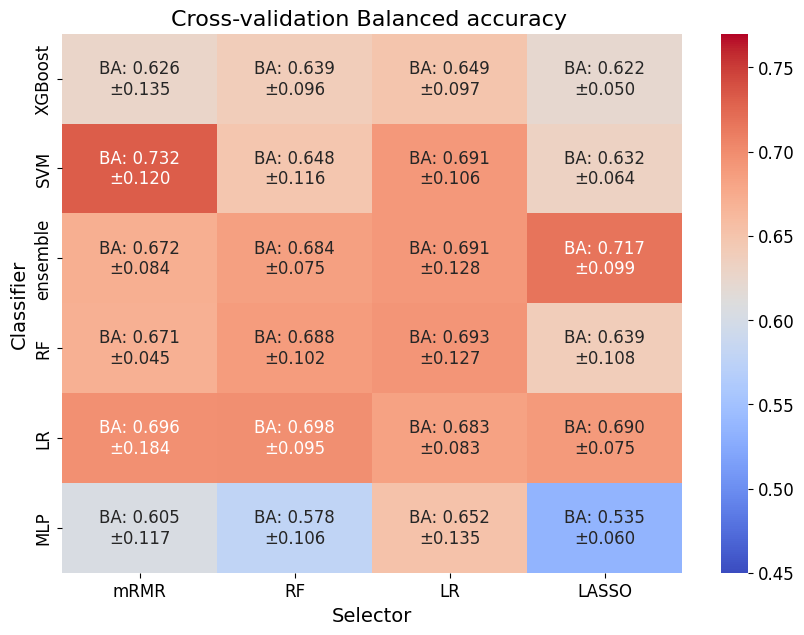

In [1300]:

heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)


for result in best_results_class_selector:
    classifier = result['classifier']
    selector = result['selector']

    if classifier is not None and selector is not None:
        avg_balaccuracy = result[metricaavg]
        std_balaccuracy = result[metricastd]
        
        heatmap_data.loc[classifier, selector] = avg_balaccuracy
        
        annotations.loc[classifier, selector] = (
            f"{labell}: {avg_balaccuracy:.3f}\n"
            f"±{std_balaccuracy:.3f}"
        )

heatmap_data = heatmap_data.astype(float).fillna(0)


vmin = 0.45  # Min for colour mapping
vmax = 0.77  # Max for colour mapping


# Aumenta la dimensione del testo
plt.figure(figsize=(10, 7))
heatmap=sns.heatmap(
    heatmap_data, 
    annot=annotations, 
    fmt="", 
    cmap="coolwarm",
    vmin=vmin, 
    vmax=vmax,
    annot_kws={"size": 12}

)

plt.title(f"Cross-validation Balanced accuracy ", fontsize=16)
plt.ylabel('Classifier', fontsize=14)
plt.xlabel('Selector', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12) 
plt.show()



###  ROC single plot

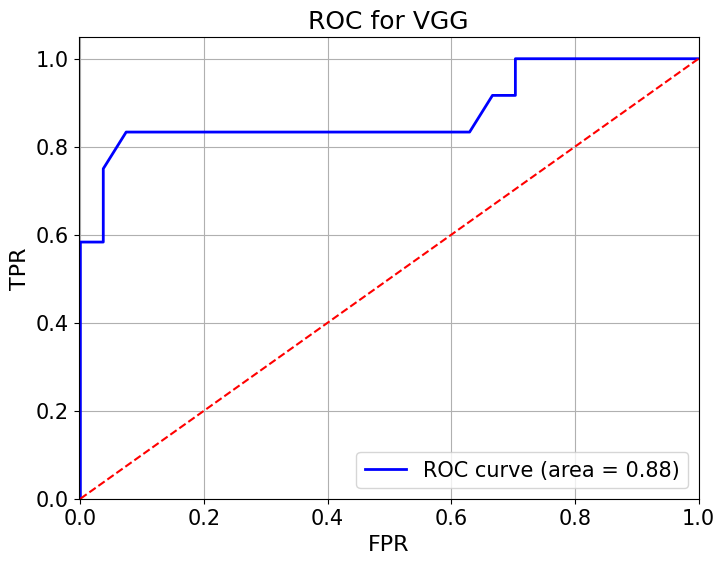

In [1199]:
y_true = y_test
y_scores = best_case_test['y_proba'] 

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5)
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.title(f'ROC for {network_name}', fontsize=18)
plt.legend(loc='lower right', fontsize=15)
plt.grid()

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


###  ROC multiple networks plot

In [48]:
roc_results={}

In [49]:
roc_results [network_name]= {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

NameError: name 'fpr' is not defined

In [50]:
### ROC CURVE OVERLAPPED of all the networks
plt.figure(figsize=(10, 8))
plt.plot(roc_results['IncRes']['fpr'], roc_results['IncRes']['tpr'], color='blue', label=f'IncRes (area = {roc_results["IncRes"]["roc_auc"]:.2f})')
plt.plot(roc_results['ResNet']['fpr'], roc_results['ResNet']['tpr'], color='orange', label=f'RES (area = {roc_results["ResNet"]["roc_auc"]:.2f})')
plt.plot(roc_results['VGG']['fpr'], roc_results['VGG']['tpr'], color='green', label=f'VGG (area = {roc_results["VGG"]["roc_auc"]:.2f})')
#plt.plot(roc_results['Rad']['fpr'], roc_results['Rad']['tpr'], color='purple', label=f'Rad (area = {roc_results["Rad"]["roc_auc"]:.2f})')
plt.plot(roc_results['Inception']['fpr'], roc_results['Inception']['tpr'], color='red', label=f'INC (area = {roc_results["Inception"]["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.003])
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.title('ROC Curve for different models', fontsize=16)
plt.legend(loc='lower right', fontsize=12) 
plt.grid()
plt.show() 

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


KeyError: 'IncRes'

<Figure size 1000x800 with 0 Axes>

## Ensemble 2D

In [221]:
### choose the image type between ["Full", "Cut"]
type_image='Cut'

networks=['VGG', 'ResNet', 'Inception', 'IncRes', 'Rad']
y_pred={}

for network in networks:
    print("Starting with ", network)
    
    if (network=='Rad'):
        file_path = f"../CSVFeatures/2D/Radiomica_Wavelet_2D.csv" 
        selected_features=np.loadtxt(f"../trainedmodels2D//selected_features_{network}.csv", delimiter=",")
        selected_features = selected_features.astype(int)
        trained_classifier_filename=(f"../trainedmodels2D/2D{network}")
        df = pd.read_csv(file_path, sep=',')

        # Remove unnecessary columns
        columns_to_remove = [
            'Slice',
            'diagnostics_Image-original_Mean',
            'diagnostics_Image-original_Minimum',
            'diagnostics_Image-original_Maximum',
            'diagnostics_Mask-original_VoxelNum',
            'diagnostics_Mask-original_VolumeNum',
        ]

        df_cleaned = df.drop(columns=columns_to_remove)
        df_features = df_cleaned.drop(columns=['Paziente'])

        features = df_features.to_numpy()
        print(f"Number of features for {network}: ", features.shape[1])  
    else:
        file_path = f"../CSVFeatures/2D/{type_image}/{network}_SliceMaggiore_{type_image}.csv" 
        ### Load the selected features and the trained classifier
        selected_features=np.loadtxt(f"../trainedmodels2D/{type_image}/selected_features_{network}.csv", delimiter=",")
        selected_features = selected_features.astype(int)

        try:
            if len(selected_features) == 0:
                print()
        except TypeError:
              selected_features = np.array([selected_features])
  
        trained_classifier_filename=(f"../trainedmodels2D/{type_image}/{network}")

        df = pd.read_csv(file_path, sep=',')

        df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

        df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

        df_features = df_ordered.drop(columns=['Unnamed: 0'])

        features = df_features.to_numpy()

        #print(features)
        print(f"Number of features for {network}: ", features.shape[1])  

    
    
    with open(trained_classifier_filename, 'rb') as file:
        trained_classifier = pickle.load(file)


    Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False)
    original_features=np.arange(X_train.shape[1])


    ## FEATURE CORRELATION

    X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.9)
    X_test_reduced = np.delete(X_test, dropped_features, axis=1)

    # Removal of features with high ANOVA F-test p_value
    X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
    X_test_reduced = X_test_reduced[:, features_to_keep]

    X_test_reduced= X_test_reduced[:, selected_features]
    y_pred[network] = trained_classifier.predict(X_test_reduced)




Starting with  VGG
Number of features for VGG:  512
Starting with  ResNet
Number of features for ResNet:  2048
Starting with  Inception
Number of features for Inception:  2048
Starting with  IncRes
Number of features for IncRes:  1536
Starting with  Rad
Number of features for Rad:  474


In [220]:
### if ensemble of 4 deep networks 
y_preds_combined = np.array([y_pred['IncRes'], y_pred['ResNet'], y_pred['VGG'], y_pred['Inception']])

### if ensemble of 4 deep networks + radiomics
#y_preds_combined = np.array([y_pred['IncRes'], y_pred['ResNet'], y_pred['VGG'], y_pred['Inception'], y_pred['Rad']])

y_pred_hard = []

for i in range(y_preds_combined.shape[1]):
    predizioni_paziente = y_preds_combined[:, i]
    counts = np.bincount(predizioni_paziente)
    
    if len(counts) > 1 and counts.max() == counts.min():  # If tie put prediction = 1
        value = 1
    else:
        value = counts.argmax() 

    y_pred_hard.append(value)

bal_acc_hard = balanced_accuracy_score(y_test, y_pred_hard)
f1_hard = f1_score(y_test, y_pred_hard)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
conf_matrix_hard = confusion_matrix(y_test, y_pred_hard)

print("Hard Voting - Balanced Accuracy: ", bal_acc_hard)
print("Hard Voting - F1 Score: ", f1_hard)
print("Hard Voting - Accuracy: ", accuracy_hard)
print("Hard Voting - Confusion Matrix:\n", conf_matrix_hard)



Hard Voting - Balanced Accuracy:  0.8564814814814814
Hard Voting - F1 Score:  0.8181818181818182
Hard Voting - Accuracy:  0.8974358974358975
Hard Voting - Confusion Matrix:
 [[26  1]
 [ 3  9]]


## 2.5

#### encoders data load

In [271]:

file_path_area = "../indici_aree/aree_03.npy" ### only keep slices of at least 0.3 % of area


zip_file_path = f"../CSVFeatures/2.5D/{type_image}/{network_name}_All_Slices_{type_image}.zip"
filename_model=f"../trainedmodels2D/{type_image}/{network_name}"
original_2Dfeatures=np.loadtxt(f"../trainedmodels2D/{type_image}/original_2Dfeatures_{network_name}.csv", delimiter=",")
original_2Dfeatures = original_2Dfeatures.astype(int)


arraytuple = np.load(file_path_area)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

arraytuple_sorted = sorted(arraytuple, key=lambda t: t[0])

patients_slices = {}
for t in arraytuple_sorted:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# you can decide how many slices to keep
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:]

# Ora creiamo una lista finale di tuple per i pazienti ordinati con le 5 slice maggiori
final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = data[
    data.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Percorso del secondo file zip contenente il secondo CSV
second_zip_file_path = "../CSVFeatures/2.5D/Radiomica_Wavelet_25D.csv.zip"

# Apri il secondo file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(second_zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    second_csv_filename = zip_ref.namelist()[0]
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(second_csv_filename) as second_csv_file:
        second_csv = pd.read_csv(second_csv_file)

# Controlla che gli indici delle slice di ogni paziente siano presenti nel secondo CSV
for patient_id in patients_slices:
    slices_in_first = [t[1] for t in patients_slices[patient_id]]
    slices_in_second = second_csv[second_csv['Paziente'] == patient_id]['Slice'].tolist()
    
    # Se uno degli indici di slice non è presente nel secondo CSV, stampa un errore
    if not set(slices_in_first).issubset(set(slices_in_second)):
        print(f"Errore: alcune slice del paziente {patient_id} non sono presenti nel secondo CSV.")
        exit()

# Creazione delle ultime variabili se il controllo è ok
filtered_patients = []

for patient_id in sorted(patients_slices):
    # Filtra i dati per il paziente specifico
    filtered_patient_data = filtered_data[filtered_data['Patient'] == patient_id]
    
    # Dopo aver filtrato per paziente, rimuovi le prime due colonne ('Patient' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le prime due colonne siano state rimosse
print(filtered_patient_data.head())

with open(filename_model, 'rb') as file:
    classifierinitialized = pickle.load(file)


patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)
patients_train2, patients_val, y_train2, y_val, features_train2, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=4)

print("Number of train patients: ", len(features_train1))
print("Number of test patients: ", len(features_test))

print("Number of features for every image: ", len(features_train1[0][0]) )


      Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
2805   3.136094   0.000000   2.086880    0.01537   1.312771   0.055483   
2806   2.882869   0.018774   1.897128    0.00000   1.388809   0.057514   
2807   2.941883   0.066669   1.686883    0.00000   1.399048   0.044942   
2808   2.959555   0.000000   1.794989    0.00000   1.445577   0.055340   
2809   3.134180   0.000000   1.930265    0.00000   1.369479   0.050503   

      Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_2038  \
2805   0.000000   0.029518   0.958965   0.393159  ...      0.652400   
2806   0.000000   0.050396   1.183745   0.453114  ...      0.616766   
2807   0.000000   0.049127   1.396494   0.454533  ...      0.581172   
2808   0.000000   0.055616   1.565372   0.489011  ...      0.524342   
2809   0.145919   0.060376   1.640102   0.607325  ...      0.167897   

      Feature_2039  Feature_2040  Feature_2041  Feature_2042  Feature_2043  \
2805      0.660676      0.173366      1.420585    

#### radiomics data load


In [66]:
file_path = "../indici_aree/aree_03.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Percorso del file zip contenente il CSV
zip_file_path = "../CSVFeatures/2.5D/Radiomica_Wavelet_25D.csv.zip"
filename_model=f"../trainedmodels2D/2DRad"
original_2Dfeatures=np.loadtxt(f"../trainedmodels2D/original_2Dfeatures_Rad.csv", delimiter=",")
original_2Dfeatures = original_2Dfeatures.astype(int)

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Crea un dizionario con le slice e le loro aree, raggruppate per paziente
patients_slices = {}
for t in arraytuple:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)

# Crea una lista di tuple finali per i pazienti ordinati con le 5 slice maggiori
final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = data[
    data.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Filtra le colonne che iniziano con 'original' o 'dentro'
filtered_patients = []
for patient_id in loaded_patients:
    # Filtra i dati per il paziente specifico
    filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
    
    # Rimuovi le prime due colonne ('Paziente' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    # Rimuovi le colonne che iniziano con "diagnostics"
    filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le colonne "diagnostics" siano state rimosse
print(filtered_patient_data.head()[:3])

with open("../trainedmodels2D/2DRad", 'rb') as file:
    classifierinitialized = pickle.load(file)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)
patients_train2, patients_val, y_train2, y_val, features_train2, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=4)

print("Number of train patients: ", len(features_train1))
print("Number of test patients: ", len(features_test))

print("Number of features for every image: ", len(features_train1[0][0]) )

      original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
5170                     0.835730                         21.624471   
5171                     0.696211                         24.473204   
5172                     0.675586                         26.104241   

      original_shape2D_MaximumDiameter  original_shape2D_MeshSurface  \
5170                         19.924859                         131.0   
5171                         22.360680                         165.0   
5172                         24.186773                         213.0   

      original_shape2D_MinorAxisLength  original_shape2D_Perimeter  \
5170                         18.072228                   91.840620   
5171                         17.038510                   97.840620   
5172                         17.635660                  104.911688   

      original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
5170                                0.701073                      

#### functions

In [245]:
## Functions that try the 3 prediction aggregation modes to create a patient-level prediction

def prob_to_binary(predictions_proba, patient_scores, mode):
    final_predictionarray = []          
    
    if mode == 'MV':  # Majority Voting
        for p in predictions_proba:
            test_patient_predictions = []
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > 0.5 else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions) == 0) 
            count_1 = np.sum(np.array(test_patient_predictions) == 1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
    
    elif mode == 'Mean':  # Mean of probabilities
        for score in patient_scores:
            predictions_binary = 1 if score > 0.5 else 0
            final_predictionarray.append(predictions_binary)
    
    elif mode == 'Max':  # Maximum probability across both classes
        for p in predictions_proba:
            max_proba = None
            max_slice = None

            # Iterate over each slice to find the maximum probability (regardless of class)
            for proba in p:
                class_0_prob = proba[0][0]  # Probability of class 0
                class_1_prob = proba[0][1]  # Probability of class 1
           
                # Find the maximum probability between both classes for each slice
                slice_max_proba = max(class_0_prob, class_1_prob)

                # Find the slice with the maximum probability
                if max_proba is None or slice_max_proba > max_proba:
                    max_proba = slice_max_proba
                    max_slice = proba  # Store the slice with the maximum probability

            # Now use the probability of class 1 from the slice with the maximum probability for threshold comparison
            predictions_binary = 1 if max_slice[0][1] > 0.5 else 0
            final_predictionarray.append(predictions_binary)

    return final_predictionarray


def classification_method25(classifier, patients_test, y_test, features_test, modePrediction):

    patient_scores = []
    temp_array = []

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r = len(features_test[x])
        for i in range(r):
            dato = np.array(features_test[x][i]).reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:, 1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean = np.mean(patient_predictions1)

        patient_scores.append(mean)  # Contains the mean of probabilities
        temp_array.append(patient_predictions)  # Contains all probabilities

    best_prediction = prob_to_binary(temp_array, patient_scores, modePrediction)
    f1 = f1_score(y_test, best_prediction)
   
    y_test = np.array(y_test)
    best_prediction = np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    roc_auc = roc_auc_score(y_test, patient_scores)

    # Calculate balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, best_prediction)

    conf = confusion_matrix(y_test, best_prediction)

    best_case = {
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': test_accuracy,
        'confusion_matrix': conf,
        'balanced accuracy': bal_acc,
        'y_proba': patient_scores,
    }
    
    return best_case, best_prediction


#### Execute

In [272]:

# Supponiamo che features_test sia una lista di liste e che original_2Dfeatures sia il vettore di indici delle features da mantenere
features_test_filtered = []


try:
    if len(original_2Dfeatures) == 0:
                print()
except TypeError:
    original_2Dfeatures = np.array([original_2Dfeatures])
    
# Cicliamo su ogni paziente
for paziente in features_test:
    paziente_filtered = []
    
    # Cicliamo su ogni immagine del paziente
    for immagine in paziente:
        # Selezioniamo solo le features specificate in original_2Dfeatures
        immagine_filtered = [immagine[i] for i in original_2Dfeatures]
        paziente_filtered.append(immagine_filtered)
    
    features_test_filtered.append(paziente_filtered)


features_val_filtered = []

# Cicliamo su ogni paziente
for paziente in features_val:
    paziente_filtered = []
    
    # Cicliamo su ogni immagine del paziente
    for immagine in paziente:
        # Selezioniamo solo le features specificate in original_2Dfeatures
        immagine_filtered = [immagine[i] for i in original_2Dfeatures]
        paziente_filtered.append(immagine_filtered)
    
    features_val_filtered.append(paziente_filtered)

# Ora features_test_filtered contiene solo le features desiderate

print("Features number: ", len(features_test_filtered[0][0]))

Features number:  12


In [273]:
best_bal = 0
best_mode = None
best_f1 = 0

modes = ['Mean', 'Max', 'MV']

print(f"\n{'='*10} Validation metrics: {'='*10}")
for mode in modes: 
    best_case, best_prediction = classification_method25(classifierinitialized, patients_val, y_val, features_val_filtered, mode)
    
    # Print the metrics for each mode
    print(f"Mode: {mode}")
    print(f"  Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"  F1 Score: {best_case['f1']}")
    
    if best_case['balanced accuracy'] > best_bal:
        best_bal = best_case['balanced accuracy']
        best_mode = mode
        best_f1 = best_case['f1']
    elif best_case['balanced accuracy'] == best_bal:
        if best_case['f1'] > best_f1:
            best_mode = mode
            best_f1 = best_case['f1']
        elif best_case['f1'] == best_f1:
            print(f"{mode} is the same as {best_mode}")



#best_mode='Max'

best_case, best_prediction = classification_method25(classifierinitialized, patients_test, y_test, features_test_filtered, best_mode)
    
print(f"\n{'='*10} Results for Mode: {best_mode} {'='*10}\n")
print(f"ROC AUC Score: {best_case['roc_auc']:.3f}")
print(f"F1 Score: {best_case['f1']:.3f}")
print(f"Accuracy: {best_case['accuracy']:.3f}")
print(f"Balanced Accuracy: {best_case['balanced accuracy']:.3f}\n")

print("Confusion Matrix:")
print(best_case['confusion_matrix'])

print(f"\n{'='*40}\n")


========== Validation metrics: ==========
Mode: Mean
  Balanced Accuracy: 0.6583333333333333
  F1 Score: 0.6086956521739131
Mode: Max
  Balanced Accuracy: 0.6583333333333333
  F1 Score: 0.6086956521739131
Max is the same as Mean
Mode: MV
  Balanced Accuracy: 0.6166666666666667
  F1 Score: 0.5454545454545454

========== Results for Mode: Mean ==========

ROC AUC Score: 0.892
F1 Score: 0.769
Accuracy: 0.846
Balanced Accuracy: 0.843

Confusion Matrix:
[[23  4]
 [ 2 10]]




#### ROC Single classifier

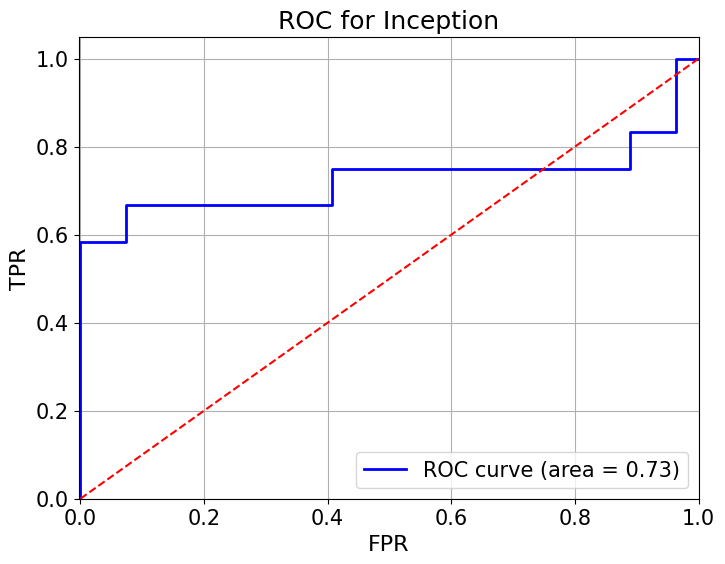

In [1509]:
# Dati
y_true = y_test
y_scores = best_case['y_proba'] 

# Calcolare i valori ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Disegnare la curva ROC con dimensioni del testo aumentate
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5)  # Linea diagonale
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.title(f'ROC for {network_name}', fontsize=18)
plt.legend(loc='lower right', fontsize=15)
plt.grid()

# Aumentare dimensione dei tick
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


#### ROC all classifiers together

In [1389]:
roc_results={}

In [1510]:
roc_results [network_name]= {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }


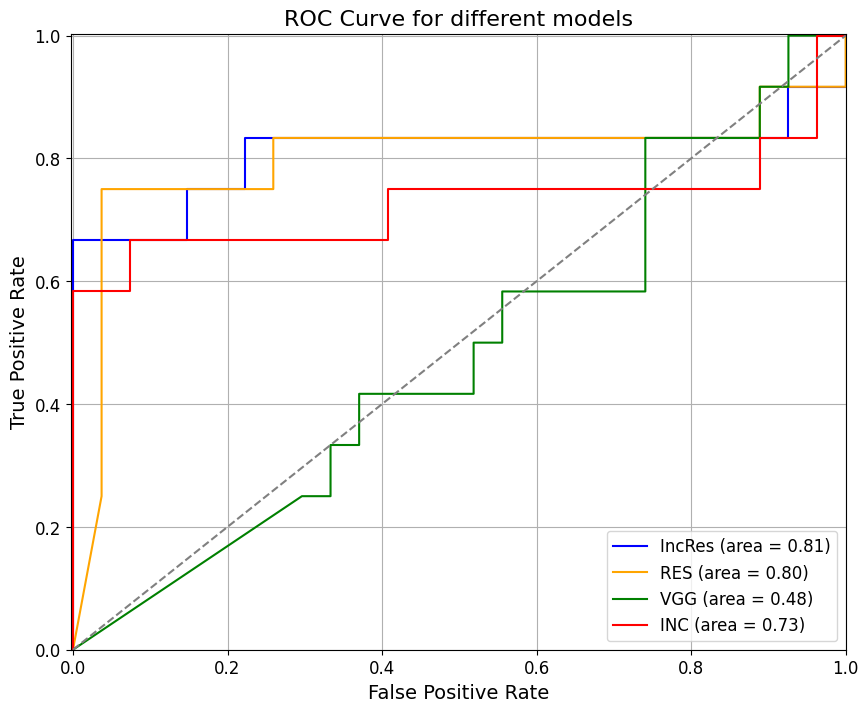

In [1511]:


# Dimensioni del grafico e plot delle curve ROC
plt.figure(figsize=(10, 8))
plt.plot(roc_results['IncRes']['fpr'], roc_results['IncRes']['tpr'], color='blue', label=f'IncRes (area = {roc_results["IncRes"]["roc_auc"]:.2f})')
plt.plot(roc_results['ResNet']['fpr'], roc_results['ResNet']['tpr'], color='orange', label=f'RES (area = {roc_results["ResNet"]["roc_auc"]:.2f})')
plt.plot(roc_results['VGG']['fpr'], roc_results['VGG']['tpr'], color='green', label=f'VGG (area = {roc_results["VGG"]["roc_auc"]:.2f})')
plt.plot(roc_results['Inception']['fpr'], roc_results['Inception']['tpr'], color='red', label=f'INC (area = {roc_results["Inception"]["roc_auc"]:.2f})')
#plt.plot(roc_results['Rad']['fpr'], roc_results['Rad']['tpr'], color='red', label=f'Rad (area = {roc_results["Rad"]["roc_auc"]:.2f})')


plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.003])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for different models', fontsize=16)
plt.legend(loc='lower right', fontsize=12) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show() 


### Ensemble 2.5D

#### function

In [260]:
def train_classifier_ensemble25(filename, mode, X_test, patients_test, original2D_features):
        # Supponiamo che features_test sia una lista di liste e che original_2Dfeatures sia il vettore di indici delle features da mantenere
        features_test_filtered = []

        # Cicliamo su ogni paziente
        for paziente in X_test:
                paziente_filtered = []
                
                # Cicliamo su ogni immagine del paziente
                for immagine in paziente:
                        # Selezioniamo solo le features specificate in original_2Dfeatures
                        immagine_filtered = [immagine[i] for i in original2D_features]
                        paziente_filtered.append(immagine_filtered)
                
                features_test_filtered.append(paziente_filtered)

        with open(filename, 'rb') as file:
                classifier= pickle.load(file)
        

        patient_scores=[]
        temp_array=[]

        for x in range(len(patients_test)):
                patient_predictions = []
                patient_predictions1 = []
                r=len(features_test_filtered[x])

                for i in range(r):
                        dato = np.array(features_test_filtered[x][i]).reshape(1, -1)
                        prediction = classifier.predict_proba(dato)
                        prediction1 = classifier.predict_proba(dato)[:,1]
                        patient_predictions.append(prediction)
                        patient_predictions1.append(prediction1)
                        mean=np.mean(patient_predictions1)

                patient_scores.append(mean) 
                temp_array.append(patient_predictions) 
        
        best_prediction=prob_to_binary(temp_array, patient_scores, mode)

        return best_prediction


#### Execute

In [286]:

file_path_area = "../indici_aree/aree_03.npy" ### only keep slices of at least 0.3 % of area

y_pred={}
networks=['ResNet', 'VGG', 'Inception', 'IncRes', 'Rad']
for network in networks:

    arraytuple = np.load(file_path_area)
    arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

    if(network=='Rad'):
        zip_file_path = "../CSVFeatures/2.5D/Radiomica_Wavelet_25D.csv.zip"
        filename_model=f"../trainedmodels2D/2DRad"
        original_2Dfeatures=np.loadtxt(f"../trainedmodels2D/original_2Dfeatures_Rad.csv", delimiter=",")
        original_2Dfeatures = original_2Dfeatures.astype(int)

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            csv_filename = zip_ref.namelist()[0]
            with zip_ref.open(csv_filename) as csv_file:
                data = pd.read_csv(csv_file)

        # Crea un dizionario con le slice e le loro aree, raggruppate per paziente
        patients_slices = {}
        for t in arraytuple:
            patient_id = t[0]
            if patient_id not in patients_slices:
                patients_slices[patient_id] = []
            patients_slices[patient_id].append(t)

        # Per ogni paziente, tieni solo le 5 slice con area maggiore
        for patient_id in patients_slices:
            patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)

        # Crea una lista di tuple finali per i pazienti ordinati con le 5 slice maggiori
        final_tuples = []
        for patient_id in sorted(patients_slices):
            final_tuples.extend(patients_slices[patient_id])

        # Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
        filtered_data = data[
            data.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
        ]

        # Filtra le colonne che iniziano con 'original' o 'dentro'
        filtered_patients = []
        for patient_id in loaded_patients:
            # Filtra i dati per il paziente specifico
            filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
            
            # Rimuovi le prime due colonne ('Paziente' e 'Slice')
            filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
            
            # Rimuovi le colonne che iniziano con "diagnostics"
            filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

            slices = []
            
            for _, slice_row in filtered_patient_data.iterrows():
                # Seleziona solo le colonne filtrate per ogni slice
                slice_features = slice_row.tolist()
                slices.append(slice_features)
            
            filtered_patients.append(slices)

    else:
        filename_model=f"../trainedmodels2D/{type_image}/{network}"
        zip_file_path = f"../CSVFeatures/2.5D/{type_image}/{network}_All_Slices_{type_image}.zip"
        
        original_2Dfeatures=np.loadtxt(f"../trainedmodels2D/{type_image}/original_2Dfeatures_{network}.csv", delimiter=",")
        original_2Dfeatures = original_2Dfeatures.astype(int)

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            csv_filename = zip_ref.namelist()[0]
            with zip_ref.open(csv_filename) as csv_file:
                data = pd.read_csv(csv_file)

        arraytuple_sorted = sorted(arraytuple, key=lambda t: t[0])

        patients_slices = {}
        for t in arraytuple_sorted:
                patient_id = t[0]
                if patient_id not in patients_slices:
                    patients_slices[patient_id] = []
                patients_slices[patient_id].append(t)

        # you can decide how many slices to keep
        for patient_id in patients_slices:
            patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:]

        final_tuples = []
        for patient_id in sorted(patients_slices):
            final_tuples.extend(patients_slices[patient_id])

        filtered_data = data[
            data.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
        ]

        second_zip_file_path = "../CSVFeatures/2.5D/Radiomica_Wavelet_25D.csv.zip"

        with zipfile.ZipFile(second_zip_file_path, 'r') as zip_ref:
            second_csv_filename = zip_ref.namelist()[0]
            with zip_ref.open(second_csv_filename) as second_csv_file:
                second_csv = pd.read_csv(second_csv_file)

        for patient_id in patients_slices:
            slices_in_first = [t[1] for t in patients_slices[patient_id]]
            slices_in_second = second_csv[second_csv['Paziente'] == patient_id]['Slice'].tolist()
            
            if not set(slices_in_first).issubset(set(slices_in_second)):
                print(f"Errore: alcune slice del paziente {patient_id} non sono presenti nel secondo CSV.")
                exit()

        filtered_patients = []
        for patient_id in sorted(patients_slices):
            filtered_patient_data = filtered_data[filtered_data['Patient'] == patient_id]
            
            filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
            
            slices = []
            
            for _, slice_row in filtered_patient_data.iterrows():
                # Seleziona solo le colonne filtrate per ogni slice
                slice_features = slice_row.tolist()
                slices.append(slice_features)
            
            filtered_patients.append(slices)



    with open(filename_model, 'rb') as file:
        classifierinitialized = pickle.load(file)


    patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)
    patients_train2, patients_val, y_train2, y_val, features_train2, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=4)

    print(f"Number of features for every image for {network} ", len(features_train1[0][0]) )
    
    features_test_filtered = []

    try:
        if len(original_2Dfeatures) == 0:
                    print()
    except TypeError:
        original_2Dfeatures = np.array([original_2Dfeatures])
        
    for paziente in features_test:
        paziente_filtered = []
        for immagine in paziente:
            immagine_filtered = [immagine[i] for i in original_2Dfeatures]
            paziente_filtered.append(immagine_filtered)
        
        features_test_filtered.append(paziente_filtered)


    features_val_filtered = []

    for paziente in features_val:
        paziente_filtered = []
        
        for immagine in paziente:
            immagine_filtered = [immagine[i] for i in original_2Dfeatures]
            paziente_filtered.append(immagine_filtered)
        
        features_val_filtered.append(paziente_filtered)

        best_bal = 0
        best_mode = None
        best_f1 = 0

        modes = ['Mean', 'Max', 'MV']

    for mode in modes: 
            best_case, best_prediction = classification_method25(classifierinitialized, patients_val, y_val, features_val_filtered, mode)

            if best_case['balanced accuracy'] > best_bal:
                best_bal = best_case['balanced accuracy']
                best_mode = mode
                best_f1 = best_case['f1']
            elif best_case['balanced accuracy'] == best_bal:
                if best_case['f1'] > best_f1:
                    best_mode = mode
                    best_f1 = best_case['f1']
                elif best_case['f1'] == best_f1:
                    print(f"{mode} is the same as {best_mode}")
                    if (mode=='Max' and best_mode=='Mean'):
                        if(type_image=='Cut'): ### per le immagini cut viene scelto mean sopra max
                            best_mode='Mean'
                        else:
                            best_mode='Max' ### per le immagini full viene scelto max sopra mean


    best_case, best_prediction = classification_method25(classifierinitialized, patients_test, y_test, features_test_filtered, best_mode)
        
    print(f"\n{'='*10} Results for Mode: {best_mode} {'='*10}\n")
    print(f"ROC AUC Score: {best_case['roc_auc']:.3f}")
    print(f"F1 Score: {best_case['f1']:.3f}")
    print(f"Accuracy: {best_case['accuracy']:.3f}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']:.3f}\n")

    print("Confusion Matrix:")
    print(best_case['confusion_matrix'])

    print(f"\n{'='*40}\n")

    y_pred[network] = train_classifier_ensemble25(filename_model, best_mode, features_test, patients_test, original_2Dfeatures)

Number of features for every image for ResNet  2048
Max is the same as Mean

========== Results for Mode: Max ==========

ROC AUC Score: 0.892
F1 Score: 0.786
Accuracy: 0.846
Balanced Accuracy: 0.866

Confusion Matrix:
[[22  5]
 [ 1 11]]


Number of features for every image for VGG  512

========== Results for Mode: Max ==========

ROC AUC Score: 0.849
F1 Score: 0.833
Accuracy: 0.897
Balanced Accuracy: 0.880

Confusion Matrix:
[[25  2]
 [ 2 10]]


Number of features for every image for Inception  2048

========== Results for Mode: Mean ==========

ROC AUC Score: 0.772
F1 Score: 0.581
Accuracy: 0.667
Balanced Accuracy: 0.690

Confusion Matrix:
[[17 10]
 [ 3  9]]


Number of features for every image for IncRes  1536
Max is the same as Mean

========== Results for Mode: Max ==========

ROC AUC Score: 0.802
F1 Score: 0.714
Accuracy: 0.795
Balanced Accuracy: 0.806

Confusion Matrix:
[[21  6]
 [ 2 10]]


Number of features for every image for Rad  474
MV is the same as Mean

========== Resul

In [287]:

## ensemble without radiomics
y_preds_combined = np.array([y_pred['IncRes'], y_pred['ResNet'], y_pred['VGG'], y_pred['Inception']])

## ensemble with radiomics
y_preds_combined = np.array([y_pred['IncRes'], y_pred['ResNet'], y_pred['VGG'], y_pred['Inception'], y_pred['Rad']])

y_pred_hard = []

# Esegui hard voting per ogni paziente
for i in range(y_preds_combined.shape[1]):
        predizioni_paziente = y_preds_combined[:, i]
        counts = np.bincount(predizioni_paziente)
        
        if len(counts) > 1 and counts.max() == counts.min():  # Caso di parità
            moda_paziente = 1  # Predizione predefinita a 1 in caso di parità
            #print(f"Parità trovata nel paziente {i} per il mode {mode}")
        else:
            moda_paziente = counts.argmax()  # Altrimenti usa la moda

        y_pred_hard.append(moda_paziente)

# Calcola le metriche per l'hard voting
bal_acc_hard = balanced_accuracy_score(y_test, y_pred_hard)
f1_hard = f1_score(y_test, y_pred_hard)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
conf_matrix_hard = confusion_matrix(y_test, y_pred_hard)

results_hard_voting = {
        'Predictions': y_pred_hard,
        'Balanced Accuracy': bal_acc_hard,
        'F1 Score': f1_hard,
        'Accuracy': accuracy_hard,
        'Confusion Matrix': conf_matrix_hard
}
    
# Stampa i risultati per questo mode
print(f"\n{'='*10} Hard Voting Results: {'='*10}\n")
print(f"Balanced Accuracy: {bal_acc_hard:.3f}")
print(f"F1 Score: {f1_hard:.3f}")
print(f"Accuracy: {accuracy_hard:.3f}")
print("Confusion Matrix:")
print(conf_matrix_hard)
print("\n" + "="*40 + "\n")



========== Hard Voting Results: ==========

Balanced Accuracy: 0.856
F1 Score: 0.818
Accuracy: 0.897
Confusion Matrix:
[[26  1]
 [ 3  9]]


